# Udacity: https://github.com/udacity/self-driving-car-sim
## Data used for training are available for download at  https://s3.amazonaws.com/video.udacity-data.com/topher/2016/December/584f6edd_data/data.zip

## Libs used

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.optimizers import Adam

Using TensorFlow backend.


## Tensorflow and Keras version used

In [2]:
import keras
print(keras.__version__)

2.2.4


In [3]:
import tensorflow
print(tensorflow.__version__)

1.8.0


## Dataset

In [4]:
df = pd.read_csv("driving_log.csv")

## Checking the data

In [5]:
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


## Checking the links of the images, and fixing them

In [6]:
df['center'][0]

'IMG/center_2016_12_01_13_30_48_287.jpg'

In [7]:
df['left'][0]

' IMG/left_2016_12_01_13_30_48_287.jpg'

In [8]:
df['right'][0]

' IMG/right_2016_12_01_13_30_48_287.jpg'

## Remove all the spaces ' IMG/right_2016_12_01_13_30_48_287.jpg'

In [9]:
df["left"] = df["left"].str.lstrip()

In [10]:
df["right"] = df["right"].str.lstrip()

## Check if everything is ok

In [11]:
df['left'][0]

'IMG/left_2016_12_01_13_30_48_287.jpg'

In [12]:
df['right'][0]

'IMG/right_2016_12_01_13_30_48_287.jpg'

In [13]:
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [14]:
len(df)

8036

## Create the image batch generator and preprocess the images. Batch norm by /255

In [15]:
def train_gen(batch_size):
    while True:
        
        steps=0
        angle = []
        img =[]
        for k,row in df.iterrows():
            
            steps = steps+1
            
            current_angle =np.float32(row['steering']) 

            #Center image
            cent_0 = cv2.imread(row['center'],-1)
            cent_0=preprop(cent_0)

            img.append(np.array(cent_0))
            angle.append(np.array(current_angle))

            img.append(np.fliplr(cent_0))
            angle.append(np.array(-current_angle))

            # Left image 
            left_0 = cv2.imread(row['left'],-1)
            left_0 = preprop(left_0)
            img.append(np.array(left_0))
            angle.append(current_angle+0.45)

            # Right image
            right_0 = cv2.imread(row['right'],-1)
            right_0 = preprop(right_0)

            img.append(np.array(right_0))
            angle.append(current_angle-0.45)
            img_reshaped = np.array(img)
            img_reshaped = img_reshaped.reshape(-1,75,75,3)
            
            if steps == batch_size:
                img=np.array(img)
                yield (np.array(img/255), np.array(angle))
                steps = 0
                angle = []
                img =[]
                
def preprop(image):
    image = cv2.cvtColor(cv2.resize(image[90:140,:], (75,75)), cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(cv2.resize(image[:-20,:,], (75,75)), cv2.COLOR_BGR2RGB)
    return image

## Generator , size 32 for one batch.

In [16]:
train_generator = train_gen(32)

## Check generator for one batch

In [17]:
image, target = next(train_generator)

## 1 batch: 32*4 = 128. [Center image, Flipped Center image, Left image, Right image ]

In [18]:
np.shape(image)

(128, 75, 75, 3)

## Check target size

In [19]:
np.shape(target)

(128,)

## Check images and targets

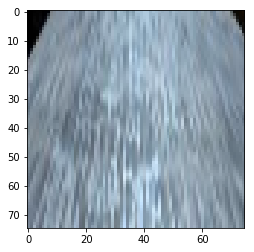

In [20]:
plt.imshow(image[0]);
# Center image

In [21]:
target[0]
# Center target

0.0

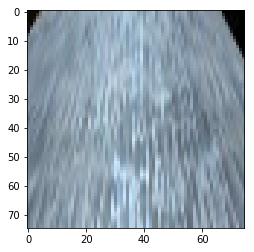

In [22]:
plt.imshow(image[1]);
# Center flipped image

In [23]:
target[1]
# Center flipped target

-0.0

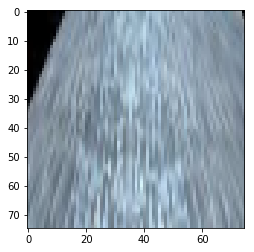

In [24]:
plt.imshow(image[2]);
# Left image

In [25]:
target[2]
# Left image target

0.45

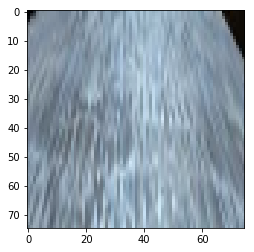

In [26]:
plt.imshow(image[3]);
# Right image

In [27]:
target[3]
# Right image target

-0.45

## Model definition.

In [28]:
model = Sequential()

model.add(Conv2D(32, (5, 5),padding="valid", strides=(2,2),input_shape=(75,75,3), activation = 'elu'))
model.add(MaxPooling2D((4,4)))
model.add(BatchNormalization())

model.add(Conv2D(16, (3, 3),padding="valid", strides=1, activation = 'elu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(256, activation='elu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())


model.add(Dense(10, activation='elu'))

model.add(Dense(1))

model.compile(optimizer = Adam(lr=0.001),loss = 'mse', metrics = ['accuracy'])

## Model summary

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 36, 36, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 32)          128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               37120     
__________

## Train

In [30]:
model.fit_generator(generator=train_generator, steps_per_epoch= 251, epochs= 6, verbose=1)

Epoch 1/6
251/251 [==============================] - 27s 108ms/step - loss: 0.2919 - acc: 0.2081
Epoch 2/6
251/251 [==============================] - 29s 115ms/step - loss: 0.0725 - acc: 0.2634
Epoch 3/6
251/251 [==============================] - 26s 104ms/step - loss: 0.0593 - acc: 0.2678
Epoch 4/6
251/251 [==============================] - 27s 106ms/step - loss: 0.0546 - acc: 0.2689
Epoch 5/6
251/251 [==============================] - 26s 104ms/step - loss: 0.0513 - acc: 0.2695
Epoch 6/6
251/251 [==============================] - 26s 104ms/step - loss: 0.0494 - acc: 0.2693


## Check the predictions that the model makes

In [31]:
preds =model.predict_generator(generator=train_generator, steps=7)

In [32]:
preds

array([[-1.12754196e-01],
       [ 4.70524579e-02],
       [ 2.96085536e-01],
       [-2.90649354e-01],
       [ 1.48337698e-02],
       [-1.13654673e-01],
       [ 3.72639894e-01],
       [-2.58558869e-01],
       [ 8.23116004e-02],
       [-4.97572273e-02],
       [ 3.62937987e-01],
       [-2.68470705e-01],
       [ 3.41031849e-02],
       [-1.14294648e-01],
       [ 3.49711359e-01],
       [-2.35471711e-01],
       [ 6.27167672e-02],
       [-1.45753607e-01],
       [ 3.67643267e-01],
       [-2.40741476e-01],
       [ 8.48558694e-02],
       [-1.28528848e-01],
       [ 3.67342263e-01],
       [-2.17867896e-01],
       [ 5.50698787e-02],
       [-1.35126114e-01],
       [ 4.10759866e-01],
       [-2.56289840e-01],
       [ 5.64559251e-02],
       [-1.23283774e-01],
       [ 4.41595852e-01],
       [-2.30763778e-01],
       [ 8.90000910e-02],
       [-8.25032741e-02],
       [ 3.72401237e-01],
       [-2.53623903e-01],
       [-4.29868698e-02],
       [-7.13728219e-02],
       [ 3.6

## Check the min-max values from the predictions

In [33]:
max(preds)

array([0.6488244], dtype=float32)

In [34]:
min(preds)

array([-0.57588226], dtype=float32)

## Save model

In [35]:
model.save('model_final.h5')

## In drive.py file add:

In [ ]:
def train_target_gen(image):
    image_array = np.asarray(image)
    image_array=cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    
    image_array = image_array[90:140,:,:]
    image_array = image_array[:-20,:,:]
    image_array = cv2.resize(image_array, (75,75))
    
    image_array = image_array.reshape(-1, 75, 75 , 3)

    yield (image_array/255)

## In telemetry function insert

In [ ]:
 steering_angle = float(model.predict_generator(train_target_gen(image), steps=1))

## Final notes: The model is able to finish the track in forward mode and backwards just after 3 epochs of training. Backwards meaning you have to turn the car around the other way of the track in the beginning then start in autonomous mode.